## 1. Import dependencies
Load data wrangling, StatsForecast modeling, feature engineering, and plotting libraries required throughout this notebook.

In [ ]:
# Standard Library
import sys
import warnings
from pathlib import Path

# Data manipulation
import pandas as pd

# Time series modeling
from statsforecast import StatsForecast
from statsforecast.models import (
    AutoETS,
    AutoTheta,
    CrostonClassic,
    HoltWinters,
    Naive,
    SeasonalNaive,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Feature engineering
import tsforge as tsf

# --- Path Configuration ---
MODULE_DIR = Path().resolve()
PROJECT_ROOT = MODULE_DIR.parent.parent
sys.path.insert(0, str(PROJECT_ROOT))

# --- Local Imports ---
from src.forecast_foundations import (
    CacheManager,
    get_notebook_name,
    find_project_root,
)

# --- Settings ---
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
PROJECT_ROOT = find_project_root()

# --- Paths ---
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

# --- Managers ---
NB_NAME = get_notebook_name()
cache = CacheManager(PROJECT_ROOT / ".cache" / NB_NAME)

# --- Output Path ---
OUTPUT_DIR = PROJECT_ROOT / "artifacts" / "02_baselines" / "output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## 2. Configure baseline model zoo
Specify the mix of classical exponential smoothing and count-specific models evaluated in cross-validation.

In [3]:
MODEL_ZOO = [
    Naive(),
    CrostonClassic(alias='Croston'),
    WindowAverage(window_size=4, alias="MA4"),  # often a strong baseline in retail forecasting
    SeasonalNaive(season_length=52, alias="SN52"),  # predict last years value
    HoltWinters(season_length=52, alias="HW52"),  # holtwinters is a special, simplified case of ETS
    AutoTheta(
        season_length=52,
        decomposition_type="multiplicative",
    ),  # automatic selection of the best Theta model/method, use multiplicative seasonlity
    AutoETS(
        season_length=52,
        model="ZZZ",
        damped=True,  # dampen the trend
        phi=0.98,
    ),  # AutoETS (Error,Trend,Seasonal) is a generalized State-Space Exponential Smoothing that automatically selects the best model
]


# data contract 
ID_COL = "unique_id"
TIME_COL = "ds"
TARGET_COL = "y"
FREQ = "W-SUN"

## 3. Load weekly training panel
Pull the preprocessed M5 weekly demand parquet that feeds every fold.

In [4]:
data = pd.read_parquet(PROJECT_ROOT / "artifacts" / "01_foundations" / "output" / "1.08.parquet")[['unique_id','ds','y']]

## 4. Initialize StatsForecast engine
Spin up a parallelized StatsForecast instance with the configured models and weekly cadence.

In [5]:
# prepare statsforecast class

stat_fcst = StatsForecast(
    models=MODEL_ZOO,
    freq=FREQ,  # set frequency to weekly
    n_jobs=-1,  # use all cpu cores
    fallback_model=Naive(),  # if we have any models that fail, fall back to naive
)


## 5. Describe rolling cross-validation blueprint
Outline the chosen windowing approach, fold count, and horizon before executing cross-validation.

* Cross-validation strategies for time series forecasting:
  * Rolling and Expanding Window: Here We Choose Rolling Window
    - this is an ideal choice for environments with ample data and volatile history

* Step Size = 1 (each fold advances by 1 time step)

* Windows = 5 (5-fold rolling window cross-validation)

* Horizon = 13

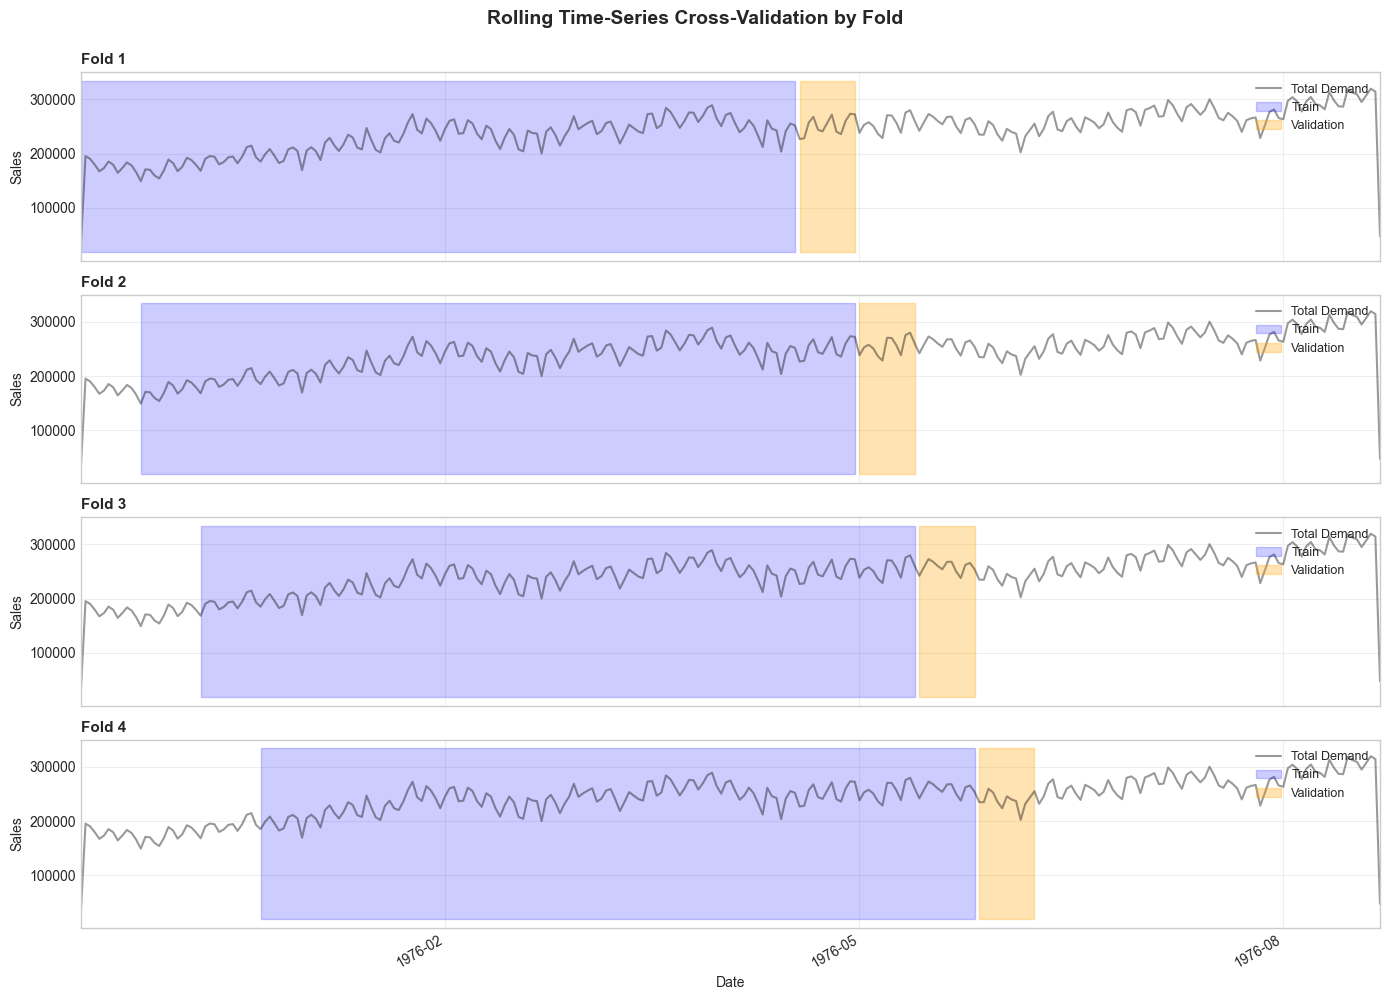

In [6]:
HORIZON = 13
WINDOWS = 4
STEP_SIZE = 13
INPUT_SIZE = 52 * 3  # 3 years

dates = data.sort_values(TIME_COL)[TIME_COL].unique()
total_sales = data.resample(FREQ, on=TIME_COL)[TARGET_COL].sum()

# Create subplots - one per fold
fig, axes = plt.subplots(WINDOWS, 1, figsize=(14, 10), sharex=True)

for i in range(WINDOWS):
    ax = axes[i]

    # Calculate indices
    tr_s, tr_e = i * STEP_SIZE, i * STEP_SIZE + INPUT_SIZE
    vl_s, vl_e = tr_e, tr_e + HORIZON

    # Map to dates
    d_tr_s, d_tr_e = dates[tr_s], dates[tr_e - 1]
    d_vl_s, d_vl_e = dates[vl_s], dates[vl_e - 1]

    # Plot total sales
    total_sales.plot(ax=ax, linewidth=1.5, color="black", alpha=0.4, label="Total Demand")

    # Get y-axis limits for fill_between
    ymin, ymax = ax.get_ylim()

    # Shade training period
    ax.fill_between(
        x=[d_tr_s, d_tr_e], y1=ymin, y2=ymax, color="blue", alpha=0.2, label="Train"
    )

    # Shade validation period
    ax.fill_between(
        x=[d_vl_s, d_vl_e], y1=ymin, y2=ymax, color="orange", alpha=0.3, label="Validation"
    )

    # Formatting
    ax.set_ylabel("Sales", fontsize=10)
    ax.set_title(f"Fold {i+1}", loc="left", fontweight="bold", fontsize=11)
    ax.legend(loc="upper right", fontsize=9)
    ax.grid(True, alpha=0.3)

# Format x-axis on bottom plot only
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
axes[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

axes[-1].set_xlabel("Date", fontsize=10)
fig.suptitle(
    "Rolling Time-Series Cross-Validation by Fold", fontweight="bold", fontsize=14, y=0.995
)

plt.tight_layout()
plt.show()


## 8. Run rolling backtest across all SKUs
Invoke StatsForecast's cross_validation helper with the configured horizon, windows, and conformal interval settings.

In [7]:
# fill all missing dates to run CV 
fill_df = tsf.fill_gaps(
    df = data,
    freq="W-SUN",
    start='global',
    id_col=ID_COL,
    time_col=TIME_COL,
).assign(**{TARGET_COL: lambda x: x[TARGET_COL].fillna(0)})

In [8]:
# statsforecast makes this easy, under the hood it repeatedly is calling .forecast() in a "for" loop 

cv_args = {
            # CV args.. 
            "h": HORIZON,
            "n_windows":WINDOWS,
            "step_size":STEP_SIZE,
            "input_size":INPUT_SIZE,
            
            # id cols 
            "id_col":ID_COL,
            "time_col":TIME_COL,
            "target_col":TARGET_COL,

            # probabalistic intervals args
            "prediction_intervals":ConformalIntervals(n_windows=2,h=HORIZON,method='conformal_distribution'),

            "level":[80,95]} # get probabalistic forecasts (to be used later.. )


cv_results = stat_fcst.cross_validation(
    **cv_args,
    df=fill_df,
)

/Users/jackrodenberg/Desktop/_frameworks/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/Users/jackrodenberg/Desktop/_frameworks/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/Users/jackrodenberg/Desktop/_frameworks/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/Users/jackrodenberg/Desktop/_frameworks/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/Users/jackrodenberg/Desktop/_frameworks/real-world-forecasting-foundations/

## 9. Sanity-check cross-validation shape
Confirm the output row count matches the expected windows × horizon per series.

In [9]:
n_ids = cv_results[ID_COL].nunique()

assert cv_results.shape[0] == (n_ids * (WINDOWS * HORIZON)), f"Expected {n_ids * (WINDOWS * HORIZON)} rows, got {cv_results.shape[0]}"

## 10. Persist cross-validation outputs
Write the full rolling backtest table to disk for downstream metric notebooks.

In [10]:
cv_results.to_parquet(OUTPUT_DIR / "statsforecast_backtest.parquet")
print(f"✓ Saved 'statsforecast_backtest' → 02_baselines/")
print(f"   Data:   output/statsforecast_backtest.parquet ({cv_results.memory_usage(deep=True).sum() / 1e6:.2f} MB, {len(cv_results):,} rows)")
print(f"\nPosixPath('{OUTPUT_DIR / 'statsforecast_backtest.parquet'}')")

✓ Saved 'statsforecast_backtest' → 02_baselines/
   Data:   output/statsforecast_backtest.parquet (488.25 MB, 1,585,480 rows)

PosixPath('/Users/jackrodenberg/Desktop/_frameworks/real-world-forecasting-foundations/artifacts/02_baselines/output/statsforecast_backtest.parquet')
